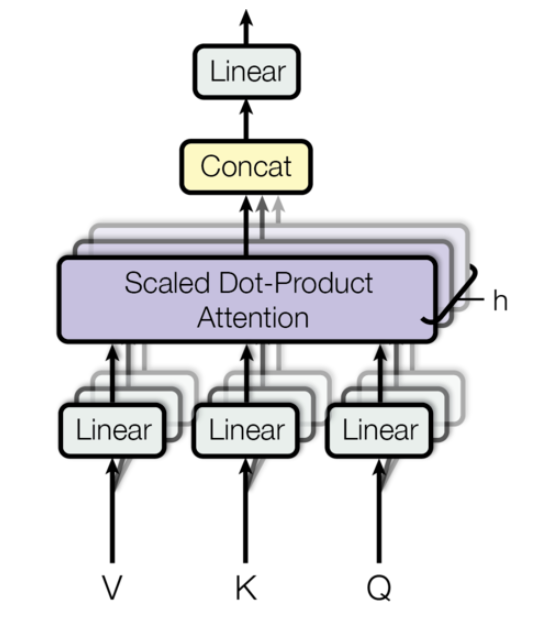

In [119]:
import math 
import torch 
from torch import nn
from typing import Optional, List
from labml import tracker

In [120]:
class PrepareForMultiHeadAttention(nn.Module):
    def __init__(self,d_model, n_heads,  d_k):
        super().__init__()
        self.n_head = n_heads
        self.d_k = d_k
        self.linear = nn.Linear(d_model, n_heads * d_k)
    def forward(self, x):
        # x shape [seq_len, batch_size , d_model]
        head_shape = x.shape[:-1] 
        x = self.linear(x) # [seq_len, batch_size , n_heads ) 
        x =x.view(*head_shape, self.n_head , self.d_k )
        return x  
    

In [121]:
x = torch.randn(10, 32, 512) # seq_len x batch_size x d_model
prepare = PrepareForMultiHeadAttention(512, 8, 64)
x = prepare(x)
print('x.shape: ', x.shape)
# print('test transpost ', x.transpose(-2,-1).shape)
print('test softmax ', nn.Softmax(dim=1)(x).shape)

x.shape:  torch.Size([10, 32, 8, 64])
test softmax  torch.Size([10, 32, 8, 64])


In [122]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout_prob):
        super().__init__()
        self.d_k = d_model // heads  # number of feature per heads
        self.heads = heads # number of heads
        self.d_model = d_model # dimension of input
        self.query = PrepareForMultiHeadAttention(d_model, heads, self.d_k)
        self.key = PrepareForMultiHeadAttention(d_model, heads, self.d_k)
        self.value = PrepareForMultiHeadAttention(d_model, heads, self.d_k)
        self.softmax = nn.Softmax(dim=1) # softmax layer for key 
        self.output = nn.Linear(d_model, d_model) # output layer
        self.drop_out = nn.Dropout(dropout_prob) # drop out layer
        self.scale = 1 / math.sqrt(self.d_k)

    def prepare_mask(self, mask: torch.Tensor, query_shape: List[int], key_shape: List[int]):
        """
        `mask` has shape `[seq_len_q, seq_len_k, batch_size]`, where first dimension is the query dimension.
        If the query dimension is equal to $1$ it will be broadcasted.
        """

        assert mask.shape[0] == 1 or mask.shape[0] == query_shape[0]
        assert mask.shape[1] == key_shape[0]
        assert mask.shape[2] == 1 or mask.shape[2] == query_shape[1]

        # Same mask applied to all heads.
        mask = mask.unsqueeze(-1)
        return mask
    def forward(self, q , k ,v , mark: Optional[torch.tensor] = None):
        query = self.query(q) # [s,b,h,d ]
        key = self.key(k) # [s,b,h,d ]
        # mask have shape [s,s,b]
        value = self.value(v) 
        # compute QK.T 
        score = torch.einsum('ibhd,jbhd->ijbh', query, key)  # [s,s,b,h]
        # apply mask
        if mark is not None:
            score = score.masked_fill(mark == 0, -1e9)
        seq_len = query.shape[0]
        batch_size = query.shape[1]
        attn = self.softmax(score * self.scale) 
        print('attn shape ', attn.shape)
        x = torch.einsum('ijbh,jbhd->ibhd', attn, value) # [s,b,h,d]
        x = x.reshape(seq_len , batch_size , self.d_model) # [s,b,d]
        print('x shape ', x.shape)
        x = self.output(x)
        return x
        

In [123]:
q = torch.randn(10, 32, 512) # seq_len x batch_size x d_model
k = torch.randn(10, 32, 512) # seq_len x batch_size x d_model
v = torch.randn(10, 32, 512) # seq_len x batch_size x d_model
multi_head = MultiHeadAttention(8, 512, 0.1)
out = multi_head(q,k,v)
print('output shape ' , out.shape)


attn shape  torch.Size([10, 10, 32, 8])
x shape  torch.Size([10, 32, 512])
output shape  torch.Size([10, 32, 512])
